# Plotting COVID-19 data

Script produced by [Laurent Lessard](https://laurentlessard.com)

All data come from the [Johns Hopkins Center for Systems Science and Engineering](https://systems.jhu.edu/)

### Import data from JHU CSSE

In [12]:
import pandas as pd

url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
df_raw = pd.read_csv(url)

### Reformat data into convenient form

In [13]:
colnames = df_raw.columns

# aggregate by region
df = df_raw.pivot_table(index='Country/Region',values=colnames[4:],aggfunc=sum)

# make countries columns rather than rows
df = df.T

# make the index a datetime object
df = df.reindex( pd.to_datetime(df.index) )

# sort the dates/times
df.sort_index(inplace=True)

### List of countries with at least 50 deaths

In [14]:
countries = df.columns[df.iloc[-1] >= 50]

for (i,c) in enumerate(countries):
    print( c.ljust(20), end=' ')
    if i % 5 == 0:
        print()

Belgium              
Brazil               China                France               Germany              Indonesia            
Iran                 Italy                Korea, South         Netherlands          Portugal             
Spain                Sweden               Switzerland          Turkey               US                   
United Kingdom       

### Plot shifted death toll for selected countries

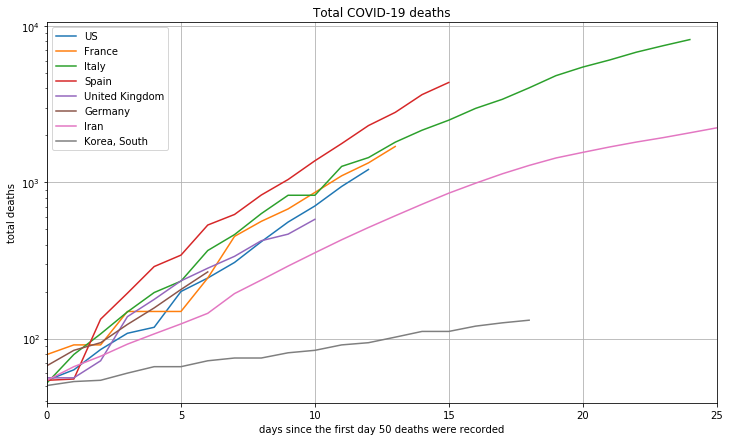

In [15]:
# minimum number of deaths
min_deaths = 50

# selected countries
countries = ['US','France','Italy','Spain','United Kingdom','Germany','Iran', 'Korea, South']

# shift data so that index corresponds to days since min_death deaths.
shifted_data = []
for (c,data) in df[countries].items():
    shifted_data.append( data[data >= min_deaths].reset_index(drop=True) )

# merge into a single dataframe
dfx = pd.concat( shifted_data, axis=1 )

# make plot
ax = dfx.plot(title="Total COVID-19 deaths", logy=True, figsize=(12,7), grid=True);
ax.set_xlabel("days since the first day %g deaths were recorded" % min_deaths )
ax.set_ylabel("total deaths")
ax.autoscale(enable=True, axis='x', tight=True)